In [85]:
from scipy.signal import savgol_filter
from pandas import read_csv
from numpy import array, exp
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [86]:
input_data = read_csv('Si.csv', sep=r'\t')
input_data.head()

/tmp/ipykernel_91979/3100832178.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  input_data = read_csv('Si.csv', sep=r'\t')


,eV,e1,e2
0,4.96,-10.695024,11.477120
1,4.94,-10.959845,11.626560
2,4.92,-11.225401,11.802038
3,4.90,-11.504592,11.974306
4,4.88,-11.770858,12.185425


In [87]:
e1 = array(input_data['e1'][::-1])
e2 = array(input_data['e2'][::-1])
eV = array(input_data['eV'][::-1])

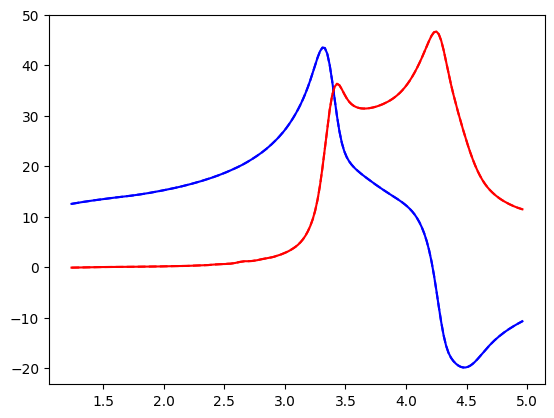

In [88]:
eV = savgol_filter(eV, 8, 2)
e1 = savgol_filter(e1, 8, 2)
e2 = savgol_filter(e2, 8, 2)
plt.plot(eV, e1, 'b')
plt.plot(eV, e2, 'r')
plt.plot(eV, UnivariateSpline(eV, e1, s=0)(eV), 'b--')
plt.plot(eV, UnivariateSpline(eV, e2, s=0)(eV), 'r--')

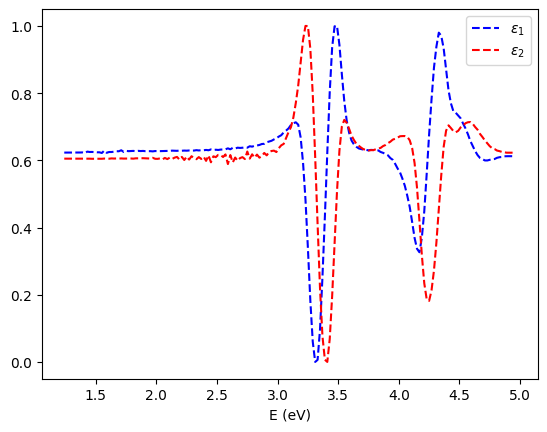

In [90]:
e1_second_der = (UnivariateSpline(eV, e1, s=0)).derivative(2)(eV)
e2_second_der = (UnivariateSpline(eV, e2, s=0)).derivative(2)(eV)
e1_second_der = savgol_filter(e1_second_der, 8, 0)
e2_second_der = savgol_filter(e2_second_der, 8, 0)
e1_second_der = (e1_second_der - e1_second_der.mean())/e1_second_der.std()
e2_second_der = (e2_second_der - e2_second_der.mean())/e2_second_der.std()
e1_second_der = (e1_second_der - e1_second_der.min())/(e1_second_der.max() - e1_second_der.min())
e2_second_der = (e2_second_der - e2_second_der.min())/(e2_second_der.max() - e2_second_der.min())
plt.plot(eV, e1_second_der, 'b--', label='$\epsilon_1$') 
plt.plot(eV, e2_second_der, 'r--', label='$\epsilon_2$')
plt.xlabel('E (eV)')
plt.legend()

In [91]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [92]:
e1 = torch.tensor(e1, requires_grad=True).to(torch.float)
e2 = torch.tensor(e2, requires_grad=True).to(torch.float)
e = torch.stack([e1, e2]).reshape(e1.shape[0],2)

In [93]:
e.shape

torch.Size([187, 2])

In [94]:
def second_der(E, m, A, E_ck, gamma, ph_angle, discrete: bool):  # wzor z JAP2017
    '''
    2nd derivative from SCPM
    :param E:
    :param m:
    :param A:
    :param E_ck:
    :param gamma:
    :param ph_angle:
    :return:
    '''
    
    if discrete:
        if m < -(1/3):
            m = -0.5
        elif m > (1/3):
            m = 0.5
        else:
            m = 0


    if m != 0:
        return (-m * (m - 1) * A * exp(1j * ph_angle) * (E - E_ck + 1j * gamma)) ** (m - 2)
    else:
        return (A * exp(1j * ph_angle) * (E - E_ck + 1j * gamma)) ** (-2)

In [95]:
class JDOS(torch.nn.Module):
    def __init__(self, e1, e2, eV) -> None:
        super(JDOS, self).__init__()

        self.e1 = torch.tensor(e1, requires_grad=True).to(torch.float)
        self.e2 = torch.tensor(e2, requires_grad=True).to(torch.float)
        self.e = torch.stack([self.e1, self.e2]).to(device).reshape(self.e1.shape[0],2)
        self.eV = torch.tensor(eV, requires_grad=True).to(torch.float).to(device)

        num_out_1 = 100
        num_out_2 = 50
        self.num_out_3 = 5
        num_out_4 = 1

        self.linear_1 = torch.nn.Linear(2, num_out_1)
        self.linear_2 = torch.nn.Linear(num_out_1, num_out_2)
        self.linear_3 = torch.nn.Linear(num_out_2, self.num_out_3)
        self.linear_4 = torch.nn.Linear(self.e1.shape[0], num_out_4)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out).reshape(self.num_out_3, self.e1.shape[0])
        out = F.relu(out)
        out = self.linear_4(out)
        out = F.sigmoid(out)
        return out
    

def train(num_epochs, lossFn, group: str, learning_rate=1e-6, seed=42, save: bool = False, plot: bool = False):
    model = JDOS(e1_second_der, e2_second_der, eV).to(device)

    torch.manual_seed(seed)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(model.e)

        outputs = outputs.detach().numpy()

        model_output = second_der()

        loss = lossFn(outputs, )

In [96]:
model = JDOS(e1_second_der, e2_second_der, eV).to(device)

In [98]:
model(model.e)

tensor([[0.4978],
        [0.5018],
        [0.5018],
        [0.5049],
        [0.4961]], device='cuda:0', grad_fn=<SigmoidBackward0>)